In [1]:
import random
import math
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from operator import add
from operator import sub

In [458]:
def genSeqBits(n):
    bitStr = []
    for i in range(int(math.pow(2,n))):
       bit = bin(i)
       bit = bit[2:]
       if len(bit) < n:
           bit = (n - len(bit))*'0' + bit
       bitStr.append(bit)
    return bitStr

## The main class that creates NK landscape and calculates scores
#alpha is the slope of the exponential function that transforms the scores to an exponential scale, ensuring that most solutions are infact "bad".
class NKLandscape:
    """ NK-landscape class """
    def __init__(self,inN,inK,inAlpha):
       self.n = inN
       self.k = inK
       self.alpha=inAlpha
       self.genNeigh()
       self.genFunc()
       self.Kbits = genSeqBits(self.k+1)
       self.max_score= self.min_max_all_sol()[3]
       
    def dispNK(self):
        print(self.n, self.k)
    """ generate neighborhood, the while function is because it wants to leave i out of the neighborhood/ there is a better way of doing this as well """
    def genNeigh(self):
        self.neighs = []
        for i in range(self.n):
            oneNeigh = random.sample(range(self.n), self.k)
            while i in oneNeigh:
                oneNeigh = random.sample(range(self.n), self.k)
            self.neighs.append(oneNeigh)
#        print 'neighs', self.neighs
    def getNeigh(self):
        return self.neighs
    """ generate function value: since totally isolated case is for k=0, for each k, we have 2^(k+1), and we need n of those """
    def genFunc(self):
        self.func = []
        for i in range(self.n):
            oneFunc = []
            for j in range(int(math.pow(2,self.k+1))):
                oneFunc.append(random.random())
            self.func.append(oneFunc)
#        print 'func', self.func
    def getFunc(self):
        return self.func
    def getN(self):
        return self.n
    def genK(self):
        return self.k
    """ compute the fitness value"""
    """ Scores are transformed via an exponential function to make most of them bad!"""
    """ This can later on change to a sigmoid function to account for satisfycing behavior of agents"""
    def compFit_raw(self, bitStr): 
        sum = 0
        for i in range(self.n):
            """ compose interacting bits """
            interBit = self.neighs[i][:]
            interBit.append(i)
            #interBit.sort()
            """ extract corresponding bits """
            bits = [ bitStr[j] for j in interBit ]
            interStr = ''.join(bits)
            """ sum up the sub-function values """ 
            #print 'i', i, 'index in func', int(interStr,2), 'interStr', interStr
            sum = sum + self.func[i][int(interStr,2)]
        x2=(sum/self.n)
            
        """the first one is an exponentital function. The second one is a sigmoid function"""
        #transformed_score=(1-np.exp(self.alpha*x2))/(1-np.exp(self.alpha))
        #transformed_score=1/(1+np.exp(-15*x2+self.alpha))
        #transformed_score=1/(1+np.exp(-20*x2+self.alpha))
        transformed_score=(1-np.exp(self.alpha*x2))/(1-np.exp(self.alpha))
        return transformed_score
    
    
    def localFit(self,bitStr,index):
        # we assume each time step change one digit
        _sum = 0
        n_g = 0
        n_change = len(index)
        for i in range(n_change):
            dex = index[i]
            interBit = self.neighs[i][:]
            interBit.append(i)
            bits = [ bitStr[j] for j in interBit ]
            interStr = ''.join(bits)
            _sum = _sum + self.func[i][int(interStr,2)]
            #else:
                #interBit = self.neighs[i][:]
                #if dex in interBit:
                    #interBit.append(i)
                    #bits = [ bitStr[j] for j in interBit ]
                    #interStr = ''.join(bits)
                    #_sum = _sum + self.func[i][int(interStr,2)]
                    #n_g += 1
        #local_score=(_sum/(n_g+1))
        local_score=_sum
        
        """the first one is an exponentital function. The second one is a sigmoid function"""
        #transformed_score=(1-np.exp(self.alpha*x2))/(1-np.exp(self.alpha))
        #transformed_score=1/(1+np.exp(-15*x2+self.alpha))
        return local_score
    
    def min_max_all_sol(self):
        All_sol=genSeqBits(self.n)
        All_scores=[]
        for s in All_sol:
            All_scores.append(self.compFit_raw(s))
        min_score=min(All_scores)
        min_index=All_scores.index(min(All_scores))
        min_solution=All_sol[min_index]
        max_score=max(All_scores)
        max_index=All_scores.index(max(All_scores))
        max_solution=All_sol[max_index]
        """deleted all_scores from teh following return...it was the last param"""
        return (min_solution,min_score/max_score,max_solution,max_score, max_score/max_score,All_scores)
    
     
    def compFit(self,bitStr):
        raw=self.compFit_raw(bitStr)
        #max_score=self.min_max_all_sol()[3]
        return (raw/self.max_score)
    
    def find_initial(self):
        All_sol=genSeqBits(self.n)
        All_scores=[]
        for s in All_sol:
            All_scores = self.compFit(s)
            if All_scores > 0.1 and All_scores < 0.2:
                break
        return s

# testing purpose
#model = NKLandscape(5,3)
#print(model.getNeigh())
#print(model.getFunc())
#print("This is the fit:",model.compFit('10101'))

# Defines an NKAgent. explore() randomly changes d bits , d is defined by distance, and then keeps it if the score is higher than the existing solution
"""Pex seems unnecessary after the change in the update rule"""
class NKAgent:
    def __init__(self,inModel,inSolution,inPex,inExplore_dist):
        self.model=inModel
        self.sol=inSolution
        self.distance=inExplore_dist
        self.pex=inPex
        self.score=self.model.compFit(self.sol)
    """randomly changes d bits, keeps it if the score is higher than existing scolution"""
    
    def explore(self):
        index=random.sample(range(len(self.sol)),self.distance)
 
        bl=list(self.sol)
        for i in index:
            if bl[i]=='0':
                bl[i]='1'
            else:
                bl[i]='0'
        tmp_sol="".join(bl)
        #global performance
        global_per = self.model.compFit(tmp_sol)
        old_global = self.score
        if self.model.compFit(tmp_sol) > self.score:
            self.sol=tmp_sol
            self.score=self.model.compFit(self.sol)
        local_per = self.model.localFit(tmp_sol,index)
        old_local = self.model.localFit(self.sol,index)
        #if local_per > old_local:
            #self.sol=tmp_sol
            #self.score = self.model.compFit(self.sol)
        #if local_per + global_per > old_local + old_global:
            #self.sol=tmp_sol
            #self.score = self.model.compFit(self.sol)
    

    def UpdateScore(self):
        self.score=self.model.compFit(self.sol)


In [459]:
#if initial_mode=0, all nodes are assigned the minimum score; if initial_mode=1, there will be a random assignment
        
def AgentsArray(M,n,model,initial_mode,Pex,Explore_dist):
    AA=[]
    #generate all binary combinations of lenght n
    if initial_mode==0:
        min_str=model.min_max_all_sol()
        for i in range(M):
            min_Agent= NKAgent(model,min_str[0],inPex=Pex,inExplore_dist=Explore_dist)
            AA.append(min_Agent)
    elif initial_mode==1:
        #TT=genSeqBits(n)
        #sys_random=random.SystemRandom()
        Set_initial = model.find_initial()
        for i in range(M):
            ThisAgent=NKAgent(model,Set_initial,inPex=Pex,inExplore_dist=Explore_dist)
            AA.append(ThisAgent)
    return AA

In [460]:
def graph_nk_init(G,n,k,asg_mode,Px, alpha, Exp_dist):
    Gtmp=G
    NKmodel=NKLandscape(n,k,alpha)
    Agents=AgentsArray(len(G),n,NKmodel,initial_mode=asg_mode,Pex=Px,Explore_dist=Exp_dist)
    agent_dict = {}
    i=0
    total_score=0
    for k in Agents:
        agent_dict[i] = k
        i=i+1
        total_score+=k.score
        
    nx.set_node_attributes(Gtmp, 'agent', agent_dict)
    return Gtmp, total_score/len(G)

In [450]:
def node_update_given(G,j,pex):
    #pex = G.node[j]['agent'].pex this also works
    nei=G.neighbors(j)
    score_list=[]
    explore_dist=G.node[j]['agent'].distance
    for i in nei:
        score_list.append([i,G.node[i]['agent'].score])
    max_nei= max(score_list, key=lambda item: item[1])
    if G.node[j]['agent'].score < max_nei[1]:
        if random.random()< pex:
            G.node[j]['agent'].explore()
        else:
            G.node[j]['agent'].sol = G.node[max_nei[0]]['agent'].sol
    else:
        G.node[j]['agent'].explore()
        #G.node[j]['agent'].sol=G.node[max_nei[0]]['agent'].sol
    
        
    G.node[j]['agent'].UpdateScore()

In [442]:
def Network_update_given(G,pex):
    total_score=0
    for i in G.nodes():
        node_update_given(G,i,pex)
        total_score += G.node[i]['agent'].score
    return total_score/len(G)

In [443]:
def Network_NK_evolution_given(G,NT,pex):
    Average_Score=[]
    for i in range(NT):
        b=Network_update_given(G,pex)
        Average_Score.append(b)
    return Average_Score

In [231]:
def Hubiness(G):
    a= nx.degree(G)
    a = [ v for v in a.values() ]
    b = sum(a)/len(a)
    m_sum = 0
    n_sum = 0
    for i in range(len(a)):
        m = (a[i] - b)**3
        n = (a[i] - b)**2
        m_sum = m_sum + m
        n_sum = n_sum + n
    if n_sum == 0:
        return 0
    else:
        return (m_sum/len(a))/((n_sum/len(a))**1.5)

In [232]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 23 13:56:54 2017

@author: pouria
"""
class Status(object):
    """
    To handle several data in one struct.

    Could be replaced by named tuple, but don't want to depend on python 2.6
    """
    node2com = {}
    total_weight = 0
    internals = {}
    degrees = {}
    gdegrees = {}

    def __init__(self):
        self.node2com = dict([])
        self.total_weight = 0
        self.degrees = dict([])
        self.gdegrees = dict([])
        self.internals = dict([])
        self.loops = dict([])

    def __str__(self):
        return ("node2com : " + str(self.node2com) + " degrees : "
                + str(self.degrees) + " internals : " + str(self.internals)
                + " total_weight : " + str(self.total_weight))

    def copy(self):
        """Perform a deep copy of status"""
        new_status = Status()
        new_status.node2com = self.node2com.copy()
        new_status.internals = self.internals.copy()
        new_status.degrees = self.degrees.copy()
        new_status.gdegrees = self.gdegrees.copy()
        new_status.total_weight = self.total_weight

    def init(self, graph, weight, part=None):
        """Initialize the status of a graph with every node in one community"""
        count = 0
        self.node2com = dict([])
        self.total_weight = 0
        self.degrees = dict([])
        self.gdegrees = dict([])
        self.internals = dict([])
        self.total_weight = graph.size(weight=weight)
        if part is None:
            for node in graph.nodes():
                self.node2com[node] = count
                deg = float(graph.degree(node, weight=weight))
                if deg < 0:
                    error = "Bad graph type ({})".format(type(graph))
                    raise ValueError(error)
                self.degrees[count] = deg
                self.gdegrees[node] = deg
                edge_data = graph.get_edge_data(node, node, {weight: 0})
                self.loops[node] = float(edge_data.get(weight, 1))
                self.internals[count] = self.loops[node]
                count += 1
        else:
            for node in graph.nodes():
                com = part[node]
                self.node2com[node] = com
                deg = float(graph.degree(node, weight=weight))
                self.degrees[com] = self.degrees.get(com, 0) + deg
                self.gdegrees[node] = deg
                inc = 0.
                for neighbor, datas in graph[node].items():
                    edge_weight = datas.get(weight, 1)
                    if edge_weight <= 0:
                        error = "Bad graph type ({})".format(type(graph))
                        raise ValueError(error)
                    if part[neighbor] == com:
                        if neighbor == node:
                            inc += float(edge_weight)
                        else:
                            inc += float(edge_weight) / 2.
                self.internals[com] = self.internals.get(com, 0) + inc
import array



#from __future__ import print_function
import networkx as nx
import array

#from community_status import Status

__author__ = """Thomas Aynaud (thomas.aynaud@lip6.fr)"""
#    Copyright (C) 2009 by
#    Thomas Aynaud <thomas.aynaud@lip6.fr>
#    All rights reserved.
#    BSD license.

__PASS_MAX = -1
__MIN = 0.0000001


def partition_at_level(dendrogram, level):
    """Return the partition of the nodes at the given level

    A dendrogram is a tree and each level is a partition of the graph nodes.
    Level 0 is the first partition, which contains the smallest communities,
    and the best is len(dendrogram) - 1.
    The higher the level is, the bigger are the communities

    Parameters
    ----------
    dendrogram : list of dict
       a list of partitions, ie dictionnaries where keys of the i+1 are the
       values of the i.
    level : int
       the level which belongs to [0..len(dendrogram)-1]

    Returns
    -------
    partition : dictionnary
       A dictionary where keys are the nodes and the values are the set it
       belongs to

    Raises
    ------
    KeyError
       If the dendrogram is not well formed or the level is too high

    See Also
    --------
    best_partition which directly combines partition_at_level and
    generate_dendrogram to obtain the partition of highest modularity

    Examples
    --------
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> dendrogram = generate_dendrogram(G)
    >>> for level in range(len(dendrogram) - 1) :
    >>>     print("partition at level", level, "is", partition_at_level(dendrogram, level))  # NOQA
    """
    partition = dendrogram[0].copy()
    for index in range(1, level + 1):
        for node, community in partition.items():
            partition[node] = dendrogram[index][community]
    return partition


def modularity(partition, graph, weight='weight'):
    """Compute the modularity of a partition of a graph

    Parameters
    ----------
    partition : dict
       the partition of the nodes, i.e a dictionary where keys are their nodes
       and values the communities
    graph : networkx.Graph
       the networkx graph which is decomposed
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'


    Returns
    -------
    modularity : float
       The modularity

    Raises
    ------
    KeyError
       If the partition is not a partition of all graph nodes
    ValueError
        If the graph has no link
    TypeError
        If graph is not a networkx.Graph

    References
    ----------
    .. 1. Newman, M.E.J. & Girvan, M. Finding and evaluating community
    structure in networks. Physical Review E 69, 26113(2004).

    Examples
    --------
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> part = best_partition(G)
    >>> modularity(part, G)
    """
    if type(graph) != nx.Graph:
        raise TypeError("Bad graph type, use only non directed graph")

    inc = dict([])
    deg = dict([])
    links = graph.size(weight=weight)
    if links == 0:
        raise ValueError("A graph without link has an undefined modularity")

    for node in graph:
        com = partition[node]
        deg[com] = deg.get(com, 0.) + graph.degree(node, weight=weight)
        for neighbor, datas in graph[node].items():
            edge_weight = datas.get(weight, 1)
            if partition[neighbor] == com:
                if neighbor == node:
                    inc[com] = inc.get(com, 0.) + float(edge_weight)
                else:
                    inc[com] = inc.get(com, 0.) + float(edge_weight) / 2.

    res = 0.
    for com in set(partition.values()):
        res += (inc.get(com, 0.) / links) - \
               (deg.get(com, 0.) / (2. * links)) ** 2
    return res


def best_partition(graph, partition=None, weight='weight', resolution=1.):
    """Compute the partition of the graph nodes which maximises the modularity
    (or try..) using the Louvain heuristices

    This is the partition of highest modularity, i.e. the highest partition
    of the dendrogram generated by the Louvain algorithm.

    Parameters
    ----------
    graph : networkx.Graph
       the networkx graph which is decomposed
    partition : dict, optional
       the algorithm will start using this partition of the nodes.
       It's a dictionary where keys are their nodes and values the communities
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    resolution :  double, optional
        Will change the size of the communities, default to 1.
        represents the time described in
        "Laplacian Dynamics and Multiscale Modular Structure in Networks",
        R. Lambiotte, J.-C. Delvenne, M. Barahona

    Returns
    -------
    partition : dictionnary
       The partition, with communities numbered from 0 to number of communities

    Raises
    ------
    NetworkXError
       If the graph is not Eulerian.

    See Also
    --------
    generate_dendrogram to obtain all the decompositions levels

    Notes
    -----
    Uses Louvain algorithm

    References
    ----------
    .. 1. Blondel, V.D. et al. Fast unfolding of communities in
    large networks. J. Stat. Mech 10008, 1-12(2008).

    Examples
    --------
    >>>  #Basic usage
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> part = best_partition(G)

    >>> #other example to display a graph with its community :
    >>> #better with karate_graph() as defined in networkx examples
    >>> #erdos renyi don't have true community structure
    >>> G = nx.erdos_renyi_graph(30, 0.05)
    >>> #first compute the best partition
    >>> partition = community.best_partition(G)
    >>>  #drawing
    >>> size = float(len(set(partition.values())))
    >>> pos = nx.spring_layout(G)
    >>> count = 0.
    >>> for com in set(partition.values()) :
    >>>     count += 1.
    >>>     list_nodes = [nodes for nodes in partition.keys()
    >>>                                 if partition[nodes] == com]
    >>>     nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                    node_color = str(count / size))
    >>> nx.draw_networkx_edges(G,pos, alpha=0.5)
    >>> plt.show()
    """
    dendo = generate_dendrogram(graph, partition, weight, resolution)
    return partition_at_level(dendo, len(dendo) - 1)


def generate_dendrogram(graph, part_init=None, weight='weight', resolution=1.):
    """Find communities in the graph and return the associated dendrogram

    A dendrogram is a tree and each level is a partition of the graph nodes.
    Level 0 is the first partition, which contains the smallest communities,
    and the best is len(dendrogram) - 1. The higher the level is, the bigger
    are the communities


    Parameters
    ----------
    graph : networkx.Graph
        the networkx graph which will be decomposed
    part_init : dict, optional
        the algorithm will start using this partition of the nodes. It's a
        dictionary where keys are their nodes and values the communities
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    resolution :  double, optional
        Will change the size of the communities, default to 1.
        represents the time described in
        "Laplacian Dynamics and Multiscale Modular Structure in Networks",
        R. Lambiotte, J.-C. Delvenne, M. Barahona

    Returns
    -------
    dendrogram : list of dictionaries
        a list of partitions, ie dictionnaries where keys of the i+1 are the
        values of the i. and where keys of the first are the nodes of graph

    Raises
    ------
    TypeError
        If the graph is not a networkx.Graph

    See Also
    --------
    best_partition

    Notes
    -----
    Uses Louvain algorithm

    References
    ----------
    .. 1. Blondel, V.D. et al. Fast unfolding of communities in large
    networks. J. Stat. Mech 10008, 1-12(2008).

    Examples
    --------
    >>> G=nx.erdos_renyi_graph(100, 0.01)
    >>> dendo = generate_dendrogram(G)
    >>> for level in range(len(dendo) - 1) :
    >>>     print("partition at level", level,
    >>>           "is", partition_at_level(dendo, level))
    :param weight:
    :type weight:
    """
    if type(graph) != nx.Graph:
        raise TypeError("Bad graph type, use only non directed graph")

    # special case, when there is no link
    # the best partition is everyone in its community
    if graph.number_of_edges() == 0:
        part = dict([])
        for node in graph.nodes():
            part[node] = node
        return [part]

    current_graph = graph.copy()
    status = Status()
    status.init(current_graph, weight, part_init)
    status_list = list()
    __one_level(current_graph, status, weight, resolution)
    new_mod = __modularity(status)
    partition = __renumber(status.node2com)
    status_list.append(partition)
    mod = new_mod
    current_graph = induced_graph(partition, current_graph, weight)
    status.init(current_graph, weight)

    while True:
        __one_level(current_graph, status, weight, resolution)
        new_mod = __modularity(status)
        if new_mod - mod < __MIN:
            break
        partition = __renumber(status.node2com)
        status_list.append(partition)
        mod = new_mod
        current_graph = induced_graph(partition, current_graph, weight)
        status.init(current_graph, weight)
    return status_list[:]


def induced_graph(partition, graph, weight="weight"):
    """Produce the graph where nodes are the communities

    there is a link of weight w between communities if the sum of the weights
    of the links between their elements is w

    Parameters
    ----------
    partition : dict
       a dictionary where keys are graph nodes and  values the part the node
       belongs to
    graph : networkx.Graph
        the initial graph
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'


    Returns
    -------
    g : networkx.Graph
       a networkx graph where nodes are the parts

    Examples
    --------
    >>> n = 5
    >>> g = nx.complete_graph(2*n)
    >>> part = dict([])
    >>> for node in g.nodes() :
    >>>     part[node] = node % 2
    >>> ind = induced_graph(part, g)
    >>> goal = nx.Graph()
    >>> goal.add_weighted_edges_from([(0,1,n*n),(0,0,n*(n-1)/2), (1, 1, n*(n-1)/2)])  # NOQA
    >>> nx.is_isomorphic(int, goal)
    True
    """
    ret = nx.Graph()
    ret.add_nodes_from(partition.values())

    for node1, node2, datas in graph.edges_iter(data=True):
        edge_weight = datas.get(weight, 1)
        com1 = partition[node1]
        com2 = partition[node2]
        w_prec = ret.get_edge_data(com1, com2, {weight: 0}).get(weight, 1)
        ret.add_edge(com1, com2, attr_dict={weight: w_prec + edge_weight})

    return ret


def __renumber(dictionary):
    """Renumber the values of the dictionary from 0 to n
    """
    count = 0
    ret = dictionary.copy()
    new_values = dict([])

    for key in dictionary.keys():
        value = dictionary[key]
        new_value = new_values.get(value, -1)
        if new_value == -1:
            new_values[value] = count
            new_value = count
            count += 1
        ret[key] = new_value

    return ret


def __load_binary(data):
    """Load binary graph as used by the cpp implementation of this algorithm
    """
    data = open(data, "rb")

    reader = array.array("I")
    reader.fromfile(data, 1)
    num_nodes = reader.pop()
    reader = array.array("I")
    reader.fromfile(data, num_nodes)
    cum_deg = reader.tolist()
    num_links = reader.pop()
    reader = array.array("I")
    reader.fromfile(data, num_links)
    links = reader.tolist()
    graph = nx.Graph()
    graph.add_nodes_from(range(num_nodes))
    prec_deg = 0

    for index in range(num_nodes):
        last_deg = cum_deg[index]
        neighbors = links[prec_deg:last_deg]
        graph.add_edges_from([(index, int(neigh)) for neigh in neighbors])
        prec_deg = last_deg

    return graph


def __one_level(graph, status, weight_key, resolution):
    """Compute one level of communities
    """
    modified = True
    nb_pass_done = 0
    cur_mod = __modularity(status)
    new_mod = cur_mod

    while modified and nb_pass_done != __PASS_MAX:
        cur_mod = new_mod
        modified = False
        nb_pass_done += 1

        for node in graph.nodes():
            com_node = status.node2com[node]
            degc_totw = status.gdegrees.get(node, 0.) / (status.total_weight * 2.)  # NOQA
            neigh_communities = __neighcom(node, graph, status, weight_key)
            __remove(node, com_node,
                     neigh_communities.get(com_node, 0.), status)
            best_com = com_node
            best_increase = 0
            for com, dnc in neigh_communities.items():
                incr = resolution * dnc - \
                       status.degrees.get(com, 0.) * degc_totw
                if incr > best_increase:
                    best_increase = incr
                    best_com = com
            __insert(node, best_com,
                     neigh_communities.get(best_com, 0.), status)
            if best_com != com_node:
                modified = True
        new_mod = __modularity(status)
        if new_mod - cur_mod < __MIN:
            break


def __neighcom(node, graph, status, weight_key):
    """
    Compute the communities in the neighborhood of node in the graph given
    with the decomposition node2com
    """
    weights = {}
    for neighbor, datas in graph[node].items():
        if neighbor != node:
            edge_weight = datas.get(weight_key, 1)
            neighborcom = status.node2com[neighbor]
            weights[neighborcom] = weights.get(neighborcom, 0) + edge_weight

    return weights


def __remove(node, com, weight, status):
    """ Remove node from community com and modify status"""
    status.degrees[com] = (status.degrees.get(com, 0.)
                           - status.gdegrees.get(node, 0.))
    status.internals[com] = float(status.internals.get(com, 0.) -
                                  weight - status.loops.get(node, 0.))
    status.node2com[node] = -1


def __insert(node, com, weight, status):
    """ Insert node into community and modify status"""
    status.node2com[node] = com
    status.degrees[com] = (status.degrees.get(com, 0.) +
                           status.gdegrees.get(node, 0.))
    status.internals[com] = float(status.internals.get(com, 0.) +
                                  weight + status.loops.get(node, 0.))


def __modularity(status):
    """
    Fast compute the modularity of the partition of the graph using
    status precomputed
    """
    links = float(status.total_weight)
    result = 0.
    for community in set(status.node2com.values()):
        in_degree = status.internals.get(community, 0.)
        degree = status.degrees.get(community, 0.)
        if links > 0:
            result += in_degree / links - ((degree / (2. * links)) ** 2)
    return result

In [233]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 23 14:15:13 2017

@author: pouria
"""
import math
import networkx as nx
import sys
import matplotlib.pyplot as plt
#import community
import random 
import collections
import numpy as np
from random import randint
import re
import math
import time
import itertools 
import pickle
import multiprocessing as mp
#import community_louvain
#produce a modular graph structure

def Graph_representing(G,part):
    
    table = [(31, 119, 180), (255, 60, 14),    
                     (148, 103, 189), (140, 86, 75),    
             (227, 119, 194), (188, 189, 34), (23, 190, 207), (158, 218, 229)] 
    color_table = [ None for i in table]
    for i in range(len(table)):    
        r, g, b = table[i]    
        color_table[i] = (r / 255., g / 255., b / 255.) 
    plt.figure()
    pos=nx.spring_layout(G)
    values = [part[i] for i in range(len(G))]
    nx.draw_networkx_nodes(G,pos,cmap=plt.get_cmap('jet'), 
                           node_color=values,node_size =200,alpha=0.3)
    nx.draw_networkx_edges(G,pos, width=2.0, alpha =0.3)
    
    #node_labels = nx.get_node_attributes(G,'node')
    #node_labels = G.nodes()
    labels = { i: None for i in range(len(G.nodes()))}
    for node,_ in G.nodes(data="False"):
        labels[node] = node;
    nx.draw_networkx_labels(G,pos,labels,font_size=10)
    #nx.draw_networkx_labels(G, pos, labels = node_labels)
    plt.show()

def modular_maker(N,k):

    G=nx.Graph()
    G.add_nodes_from(range(N))
    E = []
    for i in range(N):
        for j in range(i):
            if int(i/k) == int(j/k):
                if np.random.random() < 0.8 :
                    E.append( (i,j))
            else:
                if np.random.random() < 0.01 :
                    E.append ( (i,j))
    
    G.add_edges_from(E)
    return G
         
if __name__ == '__main__':
    
    
    N = 20
    k = 5
    #G = modular_maker(100,10)
    G = nx.erdos_renyi_graph(40, 0.2, seed=None, directed=False)
    
    #part = best_partition(G)
    #mod = modularity(part,G, weight='weight')
    #Graph_representing(G,part)              
    #print(mod)                
                    

In [2]:
# WS network
def WS_S(n,k,p):
    g = nx.watts_strogatz_graph(n, k, p, seed=None)
    while nx.is_connected(g) is False:
        g = nx.watts_strogatz_graph(n, k, p, seed=None)
    return g

In [3]:
# BA network
def BA_S(n,m):
    g = nx.barabasi_albert_graph(n, m, seed=None)
    while nx.is_connected(g) is False:
        g = nx.barabasi_albert_graph(n, m, seed=None)
    return g

In [4]:
# ER network
def ER_S(n,p):
    g = nx.erdos_renyi_graph(n, p, seed=None, directed=False)
    while nx.is_connected(g) is False:
        g = nx.erdos_renyi_graph(n, p, seed=None, directed=False)
    return g
    

In [5]:
# New BA network
def Power_L(n,m,p):
    g = nx.powerlaw_cluster_graph(n, m, p, seed=None)
    while nx.is_connected(g) is False:
        g = nx.erdos_renyi_graph(n, p, seed=None, directed=False)
    return g

/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


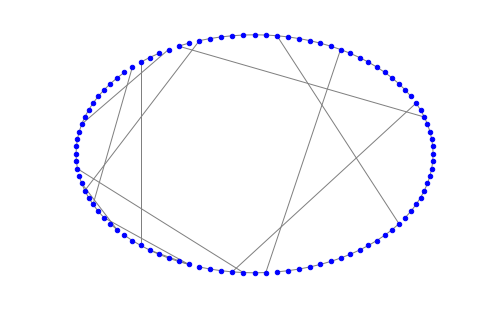

In [63]:
G = WS_S(100,2,0.1)
#pos = nx.shell_layout(G)
#pos = nx.random_layout(G)
pos = nx.circular_layout(G)
#pos = nx.spring_layout(G)
#pos =nx.fruchterman_reingold_layout(G)
#pos = nx.spectral_layout(G)
nx.draw(G, pos,node_size=20,node_color ='b',edge_color = 'gray')
plt.show()

In [65]:
# Graph Network
Total_graph = {}

G=nx.cycle_graph(50, create_using=None)
d = {'Ring':G}
Total_graph.update(d)
G = WS_S(50,4,0.1)
d = {'WS4-1':G}
Total_graph.update(d)
G = WS_S(50,4,0.2)
d = {'WS4-2':G}
Total_graph.update(d)
G = WS_S(50,4,0.4)
d = {'WS4-4':G}
Total_graph.update(d)
G = WS_S(50,8,0.1)
d = {'WS8-1':G}
Total_graph.update(d)
G = WS_S(50,8,0.2)
d = {'WS8-2':G}
Total_graph.update(d)
G = WS_S(50,8,0.4)
d = {'WS8-4':G}
Total_graph.update(d)
G = nx.random_powerlaw_tree(50, 3, seed=None, tries=5000)
d = {'Tree':G}
Total_graph.update(d)
G = ER_S(50, 0.05)
d = {'ER.05':G}
Total_graph.update(d)
G = ER_S(50, 0.1)
d = {'ER.1':G}
Total_graph.update(d)
G = ER_S(50, 0.2)
d = {'ER.2':G}
Total_graph.update(d)
G = ER_S(50, 0.4)
d = {'ER.4':G}
Total_graph.update(d)
G = BA_S(50, 2)
d = {'BA2':G}
Total_graph.update(d)
G = BA_S(50, 3)
d = {'BA3':G}
Total_graph.update(d)
G = BA_S(50, 5)
d = {'BA5':G}
Total_graph.update(d)
G = Power_L(50,2,0.1)
d = {'PL2.1':G}
Total_graph.update(d)
G = Power_L(50,2,0.2)
d = {'PL2.2':G}
Total_graph.update(d)
G = Power_L(50,2,0.4)
d = {'PL2.4':G}
Total_graph.update(d)
G = Power_L(50,3,0.1)
d = {'PL3.1':G}
Total_graph.update(d)
G = Power_L(50,3,0.2)
d = {'PL3.2':G}
Total_graph.update(d)
G = Power_L(50,3,0.4)
d = {'PL3.4':G}
Total_graph.update(d)
G = Power_L(50,5,0.1)
d = {'PL5.1':G}
Total_graph.update(d)
G = Power_L(50,5,0.2)
d = {'PL5.2':G}
Total_graph.update(d)
G = nx.star_graph(50)
d = {'Star':G}
Total_graph.update(d)
G = Power_L(50,5,0.4)
d = {'PL5.4':G}
Total_graph.update(d)
G=nx.complete_graph(50)
d = {'Complete':G}
Total_graph.update(d)

Total_graph

{'BA2': <networkx.classes.graph.Graph at 0x11adaa518>,
 'BA3': <networkx.classes.graph.Graph at 0x11df72ba8>,
 'BA5': <networkx.classes.graph.Graph at 0x11df72940>,
 'Complete': <networkx.classes.graph.Graph at 0x11df70fd0>,
 'ER.05': <networkx.classes.graph.Graph at 0x11e585a20>,
 'ER.1': <networkx.classes.graph.Graph at 0x11e5852b0>,
 'ER.2': <networkx.classes.graph.Graph at 0x11d067b00>,
 'ER.4': <networkx.classes.graph.Graph at 0x11adaa668>,
 'PL2.1': <networkx.classes.graph.Graph at 0x11df72898>,
 'PL2.2': <networkx.classes.graph.Graph at 0x11df70438>,
 'PL2.4': <networkx.classes.graph.Graph at 0x11df70080>,
 'PL3.1': <networkx.classes.graph.Graph at 0x11df70d68>,
 'PL3.2': <networkx.classes.graph.Graph at 0x11df70a20>,
 'PL3.4': <networkx.classes.graph.Graph at 0x11d0679b0>,
 'PL5.1': <networkx.classes.graph.Graph at 0x11e585908>,
 'PL5.2': <networkx.classes.graph.Graph at 0x11df70f60>,
 'PL5.4': <networkx.classes.graph.Graph at 0x11df709b0>,
 'Ring': <networkx.classes.graph.Grap

In [30]:
list(Total_graph.keys())[0]

'WS4-1'

/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


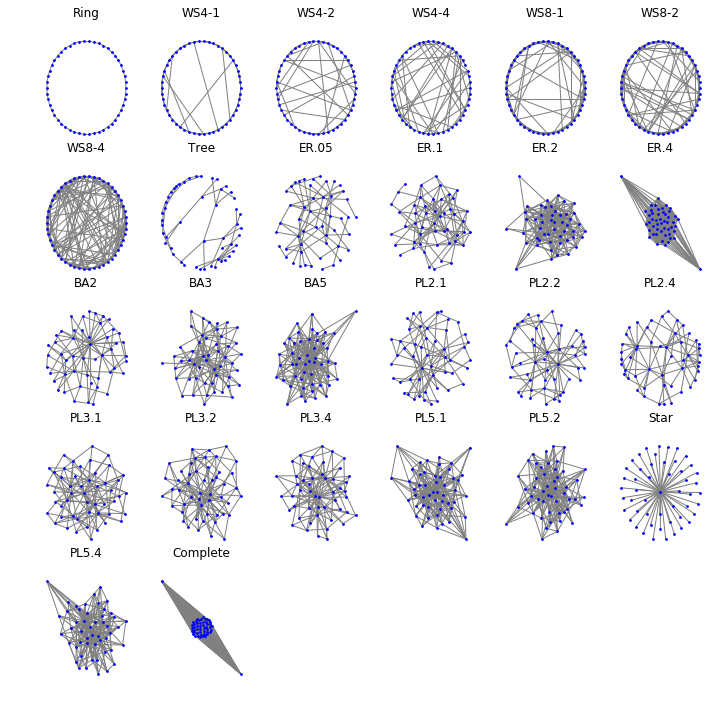

In [72]:
plt.rcParams["figure.figsize"] = (12,12)
for i in range(26):
    plt.subplot(5,6,i+1)
    G = list(Total_graph.values())[i]
    if i < 7:
        pos = nx.shell_layout(G)
        nx.draw(G, pos,node_size=3,node_color ='b',edge_color = 'gray')
        plt.title(list(Total_graph.keys())[i],y=1.08)
    else:
        pos = nx.spring_layout(G)
        nx.draw(G, pos,node_size=3,node_color ='b',edge_color = 'gray')
        plt.title(list(Total_graph.keys())[i],y=1.08)
        #plt.ylabel('Probability Density Function')
        #plt.xlabel('Distance from 90m Contour Line(nm)')
plt.show()


In [463]:
class Simulation:
    def __init__(self,in_N,in_K,in_Pex,in_Explore_dist=3):
        self.N=in_N
        self.K=in_K
        self.pex=in_Pex
        self.distance=in_Explore_dist
    def WSSimulate(self,n,k,p):
        g = WS_S(n,k,p)
        Ws_g = []
        #Ws_score = [[]]*n
        Ws_score_short = []
        Ws_score_long = []
        account_time = []
        Path = nx.average_shortest_path_length(g, weight=None)
        Tran = nx.transitivity(g)
        Deg = sum(nx.degree(g).values())/n
        Dia = nx.diameter(g, e=None)
        Hub = Hubiness(g)
        Part = best_partition(g)
        Mod = modularity(Part,g, weight='weight')
        #Ws_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
        for i in range(50):
            dif = [[]]*100
            upt = [[]]*100
            #g = Ws_g[0]
            Ws_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
            Ws_score_short.append(Network_NK_evolution_given(Ws_g[0],NT=3,pex=self.pex)[2]) 
            upt[0] = 0
            for j in range(1,100):
                upt[j] = Network_update_given(Ws_g[0],self.pex)
                dif[j] = upt[j] - upt[j-1]
                if (j > 6 and 0.001 > dif[j] >= 0 and 0.001 > dif[j-1] >= 0 and 0.001 > dif[j-2] >= 0):
                    Ws_score_long.append(upt[j])
                    break
            account_time.append(j+5)
        Mean_account = sum(account_time)/50
        Mean_score_short = sum(Ws_score_short)/50
        Mean_score_long = sum(Ws_score_long)/50
        return [Mean_account,Mean_score_short,Mean_score_long,Path,Tran,Deg,Dia,Hub,Mod,self.K,self.pex]
        #return account_time
    
    def BASimulate(self,n,m):  
        g = BA_S(n,m)
        Ba_g = []
        Ba_score_short = []
        Ba_score_long = []
        account_time = []
        Path = nx.average_shortest_path_length(g, weight=None)
        Tran = nx.transitivity(g)
        Deg = sum(nx.degree(g).values())/n
        Dia = nx.diameter(g, e=None)
        Hub = Hubiness(g)
        Part = best_partition(g)
        Mod = modularity(Part,g, weight='weight')
        #Ba_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
        for i in range(50):
            dif = [[]]*100
            upt = [[]]*100
            Ba_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
            Ba_score_short.append(Network_NK_evolution_given(Ba_g[0],NT=3,pex=self.pex)[2]) 
            upt[0] = 0
            for j in range(100):
                upt[j] = Network_update_given(Ba_g[0],self.pex)
                dif[j] = upt[j] - upt[j-1]
                if (j > 6 and 0.001 > dif[j] >= 0 and 0.001 > dif[j-1] >= 0 and 0.001 > dif[j-2] >= 0):
                    Ba_score_long.append(upt[j])
                    break
            account_time.append(j+5)
        Mean_account = sum(account_time)/50
        Mean_score_short = sum(Ba_score_short)/50
        Mean_score_long = sum(Ba_score_long)/50
        return [Mean_account,Mean_score_short,Mean_score_long,Path,Tran,Deg,Dia,Hub,Mod,self.K,self.pex]
    
    def PLSimulate(self,n,m,p):  
        g = Power_L(n,m,p)
        Po_g = []
        Po_score_short = []
        Po_score_long = []
        account_time = []
        Path = nx.average_shortest_path_length(g, weight=None)
        Tran = nx.transitivity(g)
        Deg = sum(nx.degree(g).values())/n
        Dia = nx.diameter(g, e=None)
        Hub = Hubiness(g)
        Part = best_partition(g)
        Mod = modularity(Part,g, weight='weight')
        #Po_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
        for i in range(50):
            dif = [[]]*100
            upt = [[]]*100
            Po_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
            Po_score_short.append(Network_NK_evolution_given(Po_g[0],NT=3,pex=self.pex)[2]) 
            upt[0] = 0
            for j in range(100):
                upt[j] = Network_update_given(Po_g[0],self.pex)
                dif[j] = upt[j] - upt[j-1]
                if (j > 6 and 0.001 > dif[j] >= 0 and 0.001 > dif[j-1] >= 0 and 0.001 > dif[j-2] >= 0):
                    Po_score_long.append(upt[j])
                    break
            account_time.append(j+5)
        Mean_account = sum(account_time)/50
        Mean_score_short = sum(Po_score_short)/50
        Mean_score_long = sum(Po_score_long)/50
        return [Mean_account,Mean_score_short,Mean_score_long,Path,Tran,Deg,Dia,Hub,Mod,self.K,self.pex]
    
    
    def ERSimulate(self,n,p):   
        g = ER_S(n,p)
        Er_g = []
        Er_score_short = []
        Er_score_long = []
        account_time = []
        Path = nx.average_shortest_path_length(g, weight=None)
        Tran = nx.transitivity(g)
        Deg = sum(nx.degree(g).values())/n
        Dia = nx.diameter(g, e=None)
        Hub = Hubiness(g)
        Part = best_partition(g)
        Mod = modularity(Part,g, weight='weight')
        #Er_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
        for i in range(50):
            dif = [[]]*100
            upt = [[]]*100
            Er_g = graph_nk_init(g,self.N,self.K,asg_mode=0,Px=self.pex,alpha=9,Exp_dist=self.distance)
            Er_score_short.append(Network_NK_evolution_given(Er_g[0],NT=3,pex=self.pex)[2]) 
            upt[0] = 0
            for j in range(100):
                upt[j] = Network_update_given(Er_g[0],self.pex)
                dif[j] = upt[j] - upt[j-1]
                if (j > 6 and 0.001 > dif[j] >= 0 and 0.001 > dif[j-1] >= 0 and 0.001 > dif[j-2] >= 0):
                    Er_score_long.append(upt[j])
                    break
            account_time.append(j+5)
        Mean_account = sum(account_time)/50
        Mean_score_short = sum(Er_score_short)/50
        Mean_score_long = sum(Er_score_long)/50
        return [Mean_account,Mean_score_short,Mean_score_long,Path,Tran,Deg,Dia,Hub,Mod,self.K,self.pex]
        
            
    
    def StarSimulate(self,n):
        g=nx.star_graph(n)
        St_g = []
        St_score_short = []
        St_score_long = []
        account_time = []
        Path = nx.average_shortest_path_length(g, weight=None)
        Tran = nx.transitivity(g)
        Deg = sum(nx.degree(g).values())/n
        Dia = nx.diameter(g, e=None)
        Hub = Hubiness(g)
        Part = best_partition(g)
        Mod = modularity(Part,g, weight='weight')
        #St_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
        for i in range(50):
            dif = [[]]*100
            upt = [[]]*100
            St_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
            St_score_short.append(Network_NK_evolution_given(St_g[0],NT=3,pex=self.pex)[2]) 
            upt[0] = 0
            for j in range(100):
                upt[j] = Network_update_given(St_g[0],self.pex)
                dif[j] = upt[j] - upt[j-1]
                if (j > 6 and 0.001 > dif[j] >= 0 and 0.001 > dif[j-1] >= 0 and 0.001 > dif[j-2] >= 0):
                    St_score_long.append(upt[j])
                    break
            account_time.append(j+5)
        Mean_account = sum(account_time)/50
        Mean_score_short = sum(St_score_short)/50
        Mean_score_long = sum(St_score_long)/50
        return [Mean_account,Mean_score_short,Mean_score_long,Path,Tran,Deg,Dia,Hub,Mod,self.K,self.pex]
    
    def ComSimulate(self,n):
        g=nx.complete_graph(n)
        Cm_g = []
        Cm_score_short = []
        Cm_score_long = []
        account_time = []
        Path = nx.average_shortest_path_length(g, weight=None)
        Tran = nx.transitivity(g)
        Deg = sum(nx.degree(g).values())/n
        Dia = nx.diameter(g, e=None)
        Hub = Hubiness(g)
        Part = best_partition(g)
        Mod = modularity(Part,g, weight='weight')
        #Cm_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
        for i in range(50):
            dif = [[]]*100
            upt = [[]]*100
            Cm_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
            Cm_score_short.append(Network_NK_evolution_given(Cm_g[0],NT=3,pex=self.pex)[2]) 
            upt[0] = 0
            for j in range(100):
                upt[j] = Network_update_given(Cm_g[0],self.pex)
                dif[j] = upt[j] - upt[j-1]
                if (j > 6 and 0.001 > dif[j] >= 0 and 0.001 > dif[j-1] >= 0 and 0.001 > dif[j-2] >= 0):
                    Cm_score_long.append(upt[j])
                    break
            account_time.append(j+5)
        Mean_account = sum(account_time)/50
        Mean_score_short = sum(Cm_score_short)/50
        Mean_score_long = sum(Cm_score_long)/50
        return [Mean_account,Mean_score_short,Mean_score_long,Path,Tran,Deg,Dia,Hub,Mod,self.K,self.pex]
    
    def RingSimulate(self,n):
        g=nx.cycle_graph(n, create_using=None)
        Ri_g = []
        Ri_score_short = []
        Ri_score_long = []
        account_time = []
        Path = nx.average_shortest_path_length(g, weight=None)
        Tran = nx.transitivity(g)
        Deg = sum(nx.degree(g).values())/n
        Dia = nx.diameter(g, e=None)
        Hub = Hubiness(g)
        Part = best_partition(g)
        Mod = modularity(Part,g, weight='weight')
        #Ri_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
        for i in range(50):
            dif = [[]]*100
            upt = [[]]*100
            Ri_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
            Ri_score_short.append(Network_NK_evolution_given(Ri_g[0],NT=3,pex=self.pex)[2]) 
            upt[0] = 0
            for j in range(100):
                upt[j] = Network_update_given(Ri_g[0],self.pex)
                dif[j] = upt[j] - upt[j-1]
                if (j > 6 and 0.001 > dif[j] >= 0 and 0.001 > dif[j-1] >= 0 and 0.001 > dif[j-2] >= 0):
                    Ri_score_long.append(upt[j])
                    break
            account_time.append(j+5)
        Mean_account = sum(account_time)/50
        Mean_score_short = sum(Ri_score_short)/50
        Mean_score_long = sum(Ri_score_long)/50
        return [Mean_account,Mean_score_short,Mean_score_long,Path,Tran,Deg,Dia,Hub,Mod,self.K,self.pex]
    
    def TreeSimulate(self,n,gamma):
        g=nx.random_powerlaw_tree(n, gamma, seed=None, tries=5000)
        Tr_g = []
        Tr_score_short = []
        Tr_score_long = []
        account_time = []
        Path = nx.average_shortest_path_length(g, weight=None)
        Tran = nx.transitivity(g)
        Deg = sum(nx.degree(g).values())/n
        Dia = nx.diameter(g, e=None)
        Hub = Hubiness(g)
        Part = best_partition(g)
        Mod = modularity(Part,g, weight='weight')
        #Tr_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
        for i in range(50):
            dif = [[]]*100
            upt = [[]]*100
            Tr_g = graph_nk_init(g,self.N,self.K,asg_mode=1,Px=self.pex,alpha=9,Exp_dist=self.distance)
            Tr_score_short.append(Network_NK_evolution_given(Tr_g[0],NT=3,pex=self.pex)[2]) 
            upt[0] = 0
            for j in range(100):
                upt[j] = Network_update_given(Tr_g[0],self.pex)
                dif[j] = upt[j] - upt[j-1]
                if (j > 6 and 0.001 > dif[j] >= 0 and 0.001 > dif[j-1] >= 0 and 0.001 > dif[j-2] >= 0):
                    Tr_score_long.append(upt[j])
                    break
            account_time.append(j+5)
        Mean_account = sum(account_time)/50
        Mean_score_short = sum(Tr_score_short)/50
        Mean_score_long = sum(Tr_score_long)/50
        return [Mean_account,Mean_score_short,Mean_score_long,Path,Tran,Deg,Dia,Hub,Mod,self.K,self.pex]




In [464]:
Si_1 = Simulation(in_N=10,in_K=1,in_Pex=0.2,in_Explore_dist=3)
Si_2 = Simulation(in_N=10,in_K=4,in_Pex=0.2,in_Explore_dist=3)
Si_3 = Simulation(in_N=10,in_K=7,in_Pex=0.2,in_Explore_dist=3)
Si_4 = Simulation(in_N=10,in_K=1,in_Pex=0.5,in_Explore_dist=3)
Si_5 = Simulation(in_N=10,in_K=4,in_Pex=0.5,in_Explore_dist=3)
Si_6 = Simulation(in_N=10,in_K=7,in_Pex=0.5,in_Explore_dist=3)
Si_7 = Simulation(in_N=10,in_K=1,in_Pex=0.8,in_Explore_dist=3)
Si_8 = Simulation(in_N=10,in_K=4,in_Pex=0.8,in_Explore_dist=3)
Si_9 = Simulation(in_N=10,in_K=7,in_Pex=0.8,in_Explore_dist=3)

In [ ]:
import multiprocessing as mp
import time

def f(x):
    

if __name__ == '__main__':
    start_time = time.time()
    pool = mp.Pool(processes=3)
    
    X = [1,2,3,4,5,6,7,8,9]
    
    results3 = [pool.apply_async(f, args=(x,)) for x in X]
    #results3 = [pool.apply_async(cube, args=(5,))]
    #output2 = [p.get() for p in results2]
    output3 = [p.get() for p in results3]
    #print(output2)
    print(output3)


    
    #print("--- %.5f seconds ---" % (time.time() - start_time))
    #start_time = time.time()

In [466]:
Si_9.ERSimulate(100,0.05)

[91.0,
 0.23678712271426416,
 0.19616075482836426,
 3.0242424242424244,
 0.04654771140418929,
 5.06,
 6,
 0.2718313058869541,
 0.40357605961661647,
 7,
 0.8]

In [405]:
l = []
l.append(Si_1.ERSimulate(100,0.05))
l.append(Si_2.ERSimulate(100,0.05))
l.append(Si_3.ERSimulate(100,0.05))
l.append(Si_4.ERSimulate(100,0.05))
l.append(Si_5.ERSimulate(100,0.05))
l.append(Si_6.ERSimulate(100,0.05))
l.append(Si_7.ERSimulate(100,0.05))
l.append(Si_8.ERSimulate(100,0.05))
l.append(Si_9.ERSimulate(100,0.05))
ll = []
ll.append(Si_1.ERSimulate(100,0.1))
ll.append(Si_2.ERSimulate(100,0.1))
ll.append(Si_3.ERSimulate(100,0.1))
ll.append(Si_4.ERSimulate(100,0.1))
ll.append(Si_5.ERSimulate(100,0.1))
ll.append(Si_6.ERSimulate(100,0.1))
ll.append(Si_7.ERSimulate(100,0.1))
ll.append(Si_8.ERSimulate(100,0.1))
ll.append(Si_9.ERSimulate(100,0.1))
lll = []
lll.append(Si_1.ERSimulate(100,0.2))
lll.append(Si_2.ERSimulate(100,0.2))
lll.append(Si_3.ERSimulate(100,0.2))
lll.append(Si_4.ERSimulate(100,0.2))
lll.append(Si_5.ERSimulate(100,0.2))
lll.append(Si_6.ERSimulate(100,0.2))
lll.append(Si_7.ERSimulate(100,0.2))
lll.append(Si_8.ERSimulate(100,0.2))
lll.append(Si_9.ERSimulate(100,0.2))

In [410]:
import pandas as pd
ER2_4 = pd.DataFrame(l,columns=("account","Short", "Long", "Path","Tran","Deg","Dia","Hub","Mod","K","Pex"))
ER2_4.to_csv('ER.05.csv')

In [403]:
b = []
b.append(Si_1.BASimulate(100,3))
b.append(Si_2.BASimulate(100,3))
b.append(Si_3.BASimulate(100,3))
b.append(Si_4.BASimulate(100,3))
b.append(Si_5.BASimulate(100,3))
b.append(Si_6.BASimulate(100,3))
b.append(Si_7.BASimulate(100,3))
b.append(Si_8.BASimulate(100,3))
b.append(Si_9.BASimulate(100,3))

bb = []
bb.append(Si_1.BASimulate(100,5))
bb.append(Si_2.BASimulate(100,5))
bb.append(Si_3.BASimulate(100,5))
bb.append(Si_4.BASimulate(100,5))
bb.append(Si_5.BASimulate(100,5))
bb.append(Si_6.BASimulate(100,5))
bb.append(Si_7.BASimulate(100,5))
bb.append(Si_8.BASimulate(100,5))
bb.append(Si_9.BASimulate(100,5))

f = []
f.append(Si_1.TreeSimulate(100,3))
f.append(Si_2.TreeSimulate(100,3))
f.append(Si_3.TreeSimulate(100,3))
f.append(Si_4.TreeSimulate(100,3))
f.append(Si_5.TreeSimulate(100,3))
f.append(Si_6.TreeSimulate(100,3))
f.append(Si_7.TreeSimulate(100,3))
f.append(Si_8.TreeSimulate(100,3))
f.append(Si_9.TreeSimulate(100,3))

In [418]:
import pandas as pd
WS1 = pd.DataFrame(llll,columns=("account","Short", "Long", "Path","Tran","Deg","Dia","Hub","Mod","K","Pex"))
WS1.to_csv('ER.4.csv')

In [407]:
d = []
d.append(Si_1.StarSimulate(100))
d.append(Si_2.StarSimulate(100))
d.append(Si_3.StarSimulate(100))
d.append(Si_4.StarSimulate(100))
d.append(Si_5.StarSimulate(100))
d.append(Si_6.StarSimulate(100))
d.append(Si_7.StarSimulate(100))
d.append(Si_8.StarSimulate(100))
d.append(Si_9.StarSimulate(100))

dd = []
dd.append(Si_1.ComSimulate(100))
dd.append(Si_2.ComSimulate(100))
dd.append(Si_3.ComSimulate(100))
dd.append(Si_4.ComSimulate(100))
dd.append(Si_5.ComSimulate(100))
dd.append(Si_6.ComSimulate(100))
dd.append(Si_7.ComSimulate(100))
dd.append(Si_8.ComSimulate(100))
dd.append(Si_9.ComSimulate(100))

ddd = []
ddd.append(Si_1.RingSimulate(100))
ddd.append(Si_2.RingSimulate(100))
ddd.append(Si_3.RingSimulate(100))
ddd.append(Si_4.RingSimulate(100))
ddd.append(Si_5.RingSimulate(100))
ddd.append(Si_6.RingSimulate(100))
ddd.append(Si_7.RingSimulate(100))
ddd.append(Si_8.RingSimulate(100))
ddd.append(Si_9.RingSimulate(100))

bbb = []
bbb.append(Si_1.BASimulate(100,2))
bbb.append(Si_2.BASimulate(100,2))
bbb.append(Si_3.BASimulate(100,2))
bbb.append(Si_4.BASimulate(100,2))
bbb.append(Si_5.BASimulate(100,2))
bbb.append(Si_6.BASimulate(100,2))
bbb.append(Si_7.BASimulate(100,2))
bbb.append(Si_8.BASimulate(100,2))
bbb.append(Si_9.BASimulate(100,2))

llll = []
llll.append(Si_1.ERSimulate(100,0.4))
llll.append(Si_2.ERSimulate(100,0.4))
llll.append(Si_3.ERSimulate(100,0.4))
llll.append(Si_4.ERSimulate(100,0.4))
llll.append(Si_5.ERSimulate(100,0.4))
llll.append(Si_6.ERSimulate(100,0.4))
llll.append(Si_7.ERSimulate(100,0.4))
llll.append(Si_8.ERSimulate(100,0.4))
llll.append(Si_9.ERSimulate(100,0.4))

In [419]:
p = []
p.append(Si_1.WSSimulate(100,4,0.1))
p.append(Si_2.WSSimulate(100,4,0.1))
p.append(Si_3.WSSimulate(100,4,0.1))
p.append(Si_4.WSSimulate(100,4,0.1))
p.append(Si_5.WSSimulate(100,4,0.1))
p.append(Si_6.WSSimulate(100,4,0.1))
p.append(Si_7.WSSimulate(100,4,0.1))
p.append(Si_8.WSSimulate(100,4,0.1))
p.append(Si_9.WSSimulate(100,4,0.1))

pp = []
pp.append(Si_1.WSSimulate(100,4,0.2))
pp.append(Si_2.WSSimulate(100,4,0.2))
pp.append(Si_3.WSSimulate(100,4,0.2))
pp.append(Si_4.WSSimulate(100,4,0.2))
pp.append(Si_5.WSSimulate(100,4,0.2))
pp.append(Si_6.WSSimulate(100,4,0.2))
pp.append(Si_7.WSSimulate(100,4,0.2))
pp.append(Si_8.WSSimulate(100,4,0.2))
pp.append(Si_9.WSSimulate(100,4,0.2))

ppp = []
ppp.append(Si_1.WSSimulate(100,4,0.4))
ppp.append(Si_2.WSSimulate(100,4,0.4))
ppp.append(Si_3.WSSimulate(100,4,0.4))
ppp.append(Si_4.WSSimulate(100,4,0.4))
ppp.append(Si_5.WSSimulate(100,4,0.4))
ppp.append(Si_6.WSSimulate(100,4,0.4))
ppp.append(Si_7.WSSimulate(100,4,0.4))
ppp.append(Si_8.WSSimulate(100,4,0.4))
ppp.append(Si_9.WSSimulate(100,4,0.4))

m = []
m.append(Si_1.WSSimulate(100,8,0.1))
m.append(Si_2.WSSimulate(100,8,0.1))
m.append(Si_3.WSSimulate(100,8,0.1))
m.append(Si_4.WSSimulate(100,8,0.1))
m.append(Si_5.WSSimulate(100,8,0.1))
m.append(Si_6.WSSimulate(100,8,0.1))
m.append(Si_7.WSSimulate(100,8,0.1))
m.append(Si_8.WSSimulate(100,8,0.1))
m.append(Si_9.WSSimulate(100,8,0.1))

mm = []
mm.append(Si_1.WSSimulate(100,8,0.2))
mm.append(Si_2.WSSimulate(100,8,0.2))
mm.append(Si_3.WSSimulate(100,8,0.2))
mm.append(Si_4.WSSimulate(100,8,0.2))
mm.append(Si_5.WSSimulate(100,8,0.2))
mm.append(Si_6.WSSimulate(100,8,0.2))
mm.append(Si_7.WSSimulate(100,8,0.2))
mm.append(Si_8.WSSimulate(100,8,0.2))
mm.append(Si_9.WSSimulate(100,8,0.2))

mmm = []
mmm.append(Si_1.WSSimulate(100,8,0.4))
mmm.append(Si_2.WSSimulate(100,8,0.4))
mmm.append(Si_3.WSSimulate(100,8,0.4))
mmm.append(Si_4.WSSimulate(100,8,0.4))
mmm.append(Si_5.WSSimulate(100,8,0.4))
mmm.append(Si_6.WSSimulate(100,8,0.4))
mmm.append(Si_7.WSSimulate(100,8,0.4))
mmm.append(Si_8.WSSimulate(100,8,0.4))
mmm.append(Si_9.WSSimulate(100,8,0.4))

In [436]:
import pandas as pd
WS1 = pd.DataFrame(aaa,columns=("account","Short", "Long", "Path","Tran","Deg","Dia","Hub","Mod","K","Pex"))
WS1.to_csv('PL5.4.csv')

In [426]:
q = []
q.append(Si_1.PLSimulate(100,2,0.1))
q.append(Si_2.PLSimulate(100,2,0.1))
q.append(Si_3.PLSimulate(100,2,0.1))
q.append(Si_4.PLSimulate(100,2,0.1))
q.append(Si_5.PLSimulate(100,2,0.1))
q.append(Si_6.PLSimulate(100,2,0.1))
q.append(Si_7.PLSimulate(100,2,0.1))
q.append(Si_8.PLSimulate(100,2,0.1))
q.append(Si_9.PLSimulate(100,2,0.1))

qq = []
qq.append(Si_1.PLSimulate(100,2,0.2))
qq.append(Si_2.PLSimulate(100,2,0.2))
qq.append(Si_3.PLSimulate(100,2,0.2))
qq.append(Si_4.PLSimulate(100,2,0.2))
qq.append(Si_5.PLSimulate(100,2,0.2))
qq.append(Si_6.PLSimulate(100,2,0.2))
qq.append(Si_7.PLSimulate(100,2,0.2))
qq.append(Si_8.PLSimulate(100,2,0.2))
qq.append(Si_9.PLSimulate(100,2,0.2))

qqq = []
qqq.append(Si_1.PLSimulate(100,2,0.4))
qqq.append(Si_2.PLSimulate(100,2,0.4))
qqq.append(Si_3.PLSimulate(100,2,0.4))
qqq.append(Si_4.PLSimulate(100,2,0.4))
qqq.append(Si_5.PLSimulate(100,2,0.4))
qqq.append(Si_6.PLSimulate(100,2,0.4))
qqq.append(Si_7.PLSimulate(100,2,0.4))
qqq.append(Si_8.PLSimulate(100,2,0.4))
qqq.append(Si_9.PLSimulate(100,2,0.4))

In [430]:
s = []
s.append(Si_1.PLSimulate(100,3,0.1))
s.append(Si_2.PLSimulate(100,3,0.1))
s.append(Si_3.PLSimulate(100,3,0.1))
s.append(Si_4.PLSimulate(100,3,0.1))
s.append(Si_5.PLSimulate(100,3,0.1))
s.append(Si_6.PLSimulate(100,3,0.1))
s.append(Si_7.PLSimulate(100,3,0.1))
s.append(Si_8.PLSimulate(100,3,0.1))
s.append(Si_9.PLSimulate(100,3,0.1))

ss = []
ss.append(Si_1.PLSimulate(100,3,0.2))
ss.append(Si_2.PLSimulate(100,3,0.2))
ss.append(Si_3.PLSimulate(100,3,0.2))
ss.append(Si_4.PLSimulate(100,3,0.2))
ss.append(Si_5.PLSimulate(100,3,0.2))
ss.append(Si_6.PLSimulate(100,3,0.2))
ss.append(Si_7.PLSimulate(100,3,0.2))
ss.append(Si_8.PLSimulate(100,3,0.2))
ss.append(Si_9.PLSimulate(100,3,0.2))

sss = []
sss.append(Si_1.PLSimulate(100,3,0.4))
sss.append(Si_2.PLSimulate(100,3,0.4))
sss.append(Si_3.PLSimulate(100,3,0.4))
sss.append(Si_4.PLSimulate(100,3,0.4))
sss.append(Si_5.PLSimulate(100,3,0.4))
sss.append(Si_6.PLSimulate(100,3,0.4))
sss.append(Si_7.PLSimulate(100,3,0.4))
sss.append(Si_8.PLSimulate(100,3,0.4))
sss.append(Si_9.PLSimulate(100,3,0.4))

a = []
a.append(Si_1.PLSimulate(100,5,0.1))
a.append(Si_2.PLSimulate(100,5,0.1))
a.append(Si_3.PLSimulate(100,5,0.1))
a.append(Si_4.PLSimulate(100,5,0.1))
a.append(Si_5.PLSimulate(100,5,0.1))
a.append(Si_6.PLSimulate(100,5,0.1))
a.append(Si_7.PLSimulate(100,5,0.1))
a.append(Si_8.PLSimulate(100,5,0.1))
a.append(Si_9.PLSimulate(100,5,0.1))

aa = []
aa.append(Si_1.PLSimulate(100,5,0.2))
aa.append(Si_2.PLSimulate(100,5,0.2))
aa.append(Si_3.PLSimulate(100,5,0.2))
aa.append(Si_4.PLSimulate(100,5,0.2))
aa.append(Si_5.PLSimulate(100,5,0.2))
aa.append(Si_6.PLSimulate(100,5,0.2))
aa.append(Si_7.PLSimulate(100,5,0.2))
aa.append(Si_8.PLSimulate(100,5,0.2))
aa.append(Si_9.PLSimulate(100,5,0.2))

aaa = []
aaa.append(Si_1.PLSimulate(100,5,0.4))
aaa.append(Si_2.PLSimulate(100,5,0.4))
aaa.append(Si_3.PLSimulate(100,5,0.4))
aaa.append(Si_4.PLSimulate(100,5,0.4))
aaa.append(Si_5.PLSimulate(100,5,0.4))
aaa.append(Si_6.PLSimulate(100,5,0.4))
aaa.append(Si_7.PLSimulate(100,5,0.4))
aaa.append(Si_8.PLSimulate(100,5,0.4))
aaa.append(Si_9.PLSimulate(100,5,0.4))